<a href="https://colab.research.google.com/github/rturquier/depythons/blob/main/Rendu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Projet informatique - Python pour le data scientist
##### Jérémie Stym-Popper, Luca Teodorescu, Rémi Turquier
# _La République en Marche_ est-elle de gauche ou de droite ?

[Titre provisoire]

In [1]:
# Imports
import numpy as np
import pandas as pd
from urllib import request

In [3]:
# Si difficultés à importer les modules, utiliser la méthode suivante : 
import sys
directory = r"C:\Users\Asus\Desktop\Jérémie\Fac_ENSAE\Informatique\Datapython_2AS1\Projet\new_repo_git\depythons"
sys.path.append(directory)

In [4]:
from depute_api import CPCApi

## Récupération des données
Les données ont été récupérées par l'intermédiaire de [l'API](https://github.com/regardscitoyens/nosdeputes.fr/blob/master/doc/api.md) mise à disposition par l'association Regards citoyens.

Nous avons d'abord utilisé un module nommé depute_api, que nous avons ensuite complété avec deux fonctions :
Les fonctions *interventions* et *interventions2* permettent d'entrer le nom d'un député pour obtenir une liste d'interventions (sous forme de liste de str).

Ensuite, nous avons créé plusieurs DataFrames à l'aide de la fonction interventions 2, avec les fonctions suivantes :

In [5]:
from get_dep_remi import stockintervention

Voici un exemple d'utilisation. Pour éviter de perdre du temps ici (la fonction peut mettre du temps à s'exécuter sur les échantillons de grande taille), on exécute la fonction sur un petit parti politique.

In [6]:
api = CPCApi()
deputies_json = api.parlementaires()
deputies_df = pd.json_normalize(deputies_json)

UAI_df = stockintervention("UAI")
UAI_df

4
76           Yves Jégo
80      Franck Riester
289      Maurice Leroy
515    Napole Polutele
Name: nom, dtype: object
Yves Jégo
Franck Riester
Maurice Leroy
Napole Polutele


,groupe,nom,interventions
0,UAI,Yves Jégo,"[Yves Jégo Prochaine séance, ce soir, à vingt..."
1,UAI,Franck Riester,"[ Vous pouvez compter sur le groupe UDI, Agir ..."
2,UAI,Maurice Leroy,[Maurice Leroy – Nous avons examiné la PPE en...
3,UAI,Napole Polutele,"[ Oui, madame la présidente. , Madame la mini..."


## Nettoyage des données
Après une exploration préliminaire, nous avons choisi de nous concentrer sur trois groupes parlementaires.
Nous avons sélectionné les interventions des groupes LFI (La France Insoumise) et SOC (Socialistes) pour la gauche, et le groupe LR (Les Républicains) pour la droite.
### Création de la variable cible et mise en forme *tidy*

In [7]:
### Import des données brutes récupérées avec l'API
data_url = (
    "https://raw.githubusercontent.com/rturquier/depythons/main/Stock_csv/gd2_inter.csv"
)
df_brut = pd.read_csv(data_url)
df_brut.sample(n=5)

,groupe,nom,interventions
40,LR,Julien Dive,"["" C'est laborieux ! "", ' Il est resté fidèle ..."
149,SOC,Joaquim Pueyo,"["" Je tiens à remercier mes collègues, de tous..."
65,LR,Bernard Brochand,"["" Avec 256 000 entrées, c'est maîtrisé ? "", '..."
99,LR,Jean-Charles Taugourdeau,"["" Je vous recevrai avec grand plaisir dans ma..."
59,LR,Franck Marlin,"[' On attend des réponses ! ', "" C'est certain..."


In [8]:
# Création d'une indicatrice `droite` qui sera la cible de la classification
df_brut = df_brut.assign(droite=df_brut["groupe"] == "LR")

In [9]:
# Régler un problème de type
from ast import literal_eval


def convert_to_list(interventions):
    return literal_eval(str(interventions))


df_brut["interventions"] = df_brut["interventions"].apply(convert_to_list)

In [10]:
# Séparer toutes les interventions en colonnes différentes
df_tidy = df_brut.explode("interventions")
df_tidy

,groupe,nom,interventions,droite
0,LFI,Jean-Luc Mélenchon,Ça c'est très juste ! Et ça méritait d'être d...,False
0,LFI,Jean-Luc Mélenchon,Vous avez à juste titre fait apercevoir à nos...,False
0,LFI,Jean-Luc Mélenchon,… – il n'est pas possible de compter sur une ...,False
0,LFI,Jean-Luc Mélenchon,Je voudrais féliciter notre collègue M'jid El...,False
0,LFI,Jean-Luc Mélenchon,Très bien !,False
...,...,...,...,...
167,SOC,Isabelle Santiago,Il vise également à supprimer l'alinéa 16. Le...,False
167,SOC,Isabelle Santiago,"Monsieur le Premier ministre, conséquence dir...",False
167,SOC,Isabelle Santiago,Le présent amendement propose de supprimer l'...,False
167,SOC,Isabelle Santiago,Il vise à instaurer un prélèvement sur les re...,False


In [11]:
# -- Équilibrage du nombre de d'interventions --
# Nous nous sommes posé la question de l'équilibrage des données.
# Après avoir envisagé plusieurs méthodes, nous avons choisi d'équilibrer les
# donées à la main. Ce n'est pas forcément la meilleure méthode, mais c'est
# sans doute la plus simple.
def n_droite_n_gauche(df):
    count = df.droite.value_counts()
    return count[True], count[False]


def balance_left_right(df):
    n_droite, n_gauche = n_droite_n_gauche(df)
    df = df.sort_values(by=["droite"], ascending=False)

    if n_droite > n_gauche:
        df = df[n_droite - n_gauche :]
    elif n_droite < n_gauche:
        df = df[2 * n_droite :]

    return df


df_tidy = balance_left_right(df_tidy)
n_droite_n_gauche(df_tidy)

(2454, 2454)

### Longueur des interventions et regroupement par groupes de 5 interventions

In [12]:
# Création d'une variable qui contient la longueur des interventions
df_tidy = df_tidy.assign(longueur=df_tidy["interventions"].str.len())

In [13]:
# Regroupement par groupes de 5 interventions
# Pour cela, on crée une variable `numero_paquet_de_5` qui prend la même valeur
# pour 5 députés du même bord.
n_droite, n_gauche = n_droite_n_gauche(df_tidy)

df_tidy = df_tidy.sort_values(by=["droite"], ascending=False)
df_tidy["numero_paquet_de_5"] = list(range(n_droite)) + list(range(n_gauche))
df_tidy["numero_paquet_de_5"] = np.floor(df_tidy["numero_paquet_de_5"] / 5)
df_tidy["numero_paquet_de_5"] = df_tidy["numero_paquet_de_5"].astype(int)

In [14]:
# Grouper par bord politique et par numéro de paquet de 5, puis aggréger
df_collapsed = (
    df_tidy.drop(columns=["groupe", "nom"])
    .groupby(["droite", "numero_paquet_de_5"])
    .agg({"interventions": "".join, "longueur": ["min", "max", "mean"]})
    .reset_index()
)

# Arranger le nom des colonnes
df_collapsed.columns = [
    "_".join(col).rstrip("_") for col in df_collapsed.columns.values
]

df_collapsed = df_collapsed.drop(columns="numero_paquet_de_5").rename(
    columns={"interventions_join": "interventions"}
)

## Visualisation des données (wordcloud, statistiques descriptives...)

Nous allons maintenant dans cette partie visualiser les tendances dans les différents partis, ainsi que les mots qui sont les plus utilisés. Nous commençons par le wordcloud.
Avant toutes choses, nous importons et complétons un texte de stopwords pour retirer tous les mots impertinents de la visualisation, et de la modélisation à suivre.

In [15]:
# Création d'un stopwords

stopping_list = request.urlopen(
    "https://raw.githubusercontent.com/rturquier/depythons/main/stopwords-fr.txt"
).read()
stopping_list = stopping_list.decode("utf-8")
stopwords_list = stopping_list.split("\n")

In [16]:
from wordcloud_depython import wordcloud_gen

Quelques petits essais...

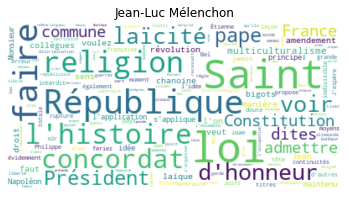

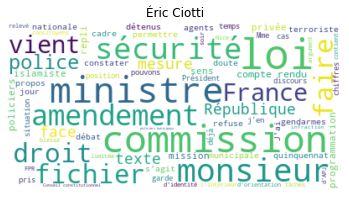

(None, None)

In [17]:
wordcloud_gen("Jean-Luc Mélenchon"), wordcloud_gen("Eric Ciotti")

### Liste de mots customisée

Nous avons créé deux fonction qui permettent de retourner les mots les plus utilisés par les membres d'un parti. Cette liste de mots va nous servir pour modéliser les champs lexicaux (quel parti a le plus tendance à utiliser tel mot ?). Nous créons cette liste de 144 mots sous le nom de *super_liste*.

In [21]:
from custom_words import super_liste

# Modéslisation

Nous passons maintenant à la partie de la modélisation. Nous avons pour cela procédé en plusieurs espace. 
1. La première consiste en la création d'une table *df_simple* qui regroupe uniquement les partis de gauche classiques (Socisalites et LFI) et le parti LR. Nous rajoutons une colonne "droite" qui renvoie **True** si le parti est de droite (LR ici), **False** sinon. Cela permettra après d'entraîner le modèle supervisé, le label étant donné par cette colonne.
2. La deuxième étape consiste à transfomrer le DataFrame contenant "Parti politique", "Nom du député" et "Interventions" en une matrice **TF-IDF**. Les détails seront donnés plus bas.
3. La deuxième étape consiste à entraîner deux modèles (ici, **RandomForestClassifier** et **SVC**) sur les données, en évaluant à chaque fois quels sont les meileurs hyperparamètres à l'aide de la méthode de validation croisée.
4. La dernière étape consiste à exécuter le modèle sur les députés du parti LREM pour prédire à quel bord politique ils pourraient potentiellement appartenir, commte tenu des mots les plus courants de leurs interventions.

#### Première étape
Nous créons d'abord la matrice df_simple

In [23]:
data_url = "https://raw.githubusercontent.com/rturquier/depythons/main/Stock_csv/gd2_inter.csv"
df_brut = pd.read_csv(data_url)
df_brut.sample(n=5)

# Création d'une indicatrice `droite` qui sera la cible de la classification
df_brut = df_brut.\
            assign(droite = df_brut["groupe"] == "LR").\
            sort_values(by = ["droite"], ascending = False)
df_brut.head()

df_simple = df_brut.assign(droite = df_brut["groupe"] == "LR")
df_simple

,groupe,nom,interventions,droite
84,LR,Gilles Lurton,"["" Monsieur le Premier ministre, vous nous ave...",True
86,LR,Jean-François Parigi,"[' Restez modeste ! ', ' Manipulation ! ', ' C...",True
100,LR,Dino Cinieri,"["" La demi-part supplémentaire qui revient de ...",True
99,LR,Jean-Charles Taugourdeau,"["" Je vous recevrai avec grand plaisir dans ma...",True
98,LR,Jérôme Nury,"["" Je vous remercie pour ces réponses claires....",True
...,...,...,...,...
136,SOC,Marietta Karamanli,"["" Je vous remercie de ces éléments et de votr...",False
137,SOC,Joël Aviragnet,"["" Il vise, lui aussi, à supprimer l'article i...",False
138,SOC,Boris Vallaud,"["" Quelle incongruité que la majorité pénale s...",False
139,SOC,Alain David,"["" Déposé par le groupe Socialistes et apparen...",False


#### Deuxième étape

Nous allons maintenant créer les matrices **Tf-Idf** qui vont nous servir pour les modèles.

In [24]:
# Voici tous les imports qui sont nécessaires pour cette partie et la suite

import collections

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report

LREM_df = pd.read_csv("https://raw.githubusercontent.com/rturquier/depythons/main/Stock_csv/LREM2_inter.csv")

Nous créons une matrice td-idf pour le DataFrame gd_df, puis nous séparons les lignes en un échantillon d'entraînement et un échantillon de test.
Ensuite nous effectuons la même chose avec le DataFrame df_simple.

In [32]:
pipe_idf = make_pipeline(CountVectorizer(vocabulary=super_liste), TfidfTransformer())

tf_idf_simple = pipe_idf2.fit_transform(df_simple['interventions'].values.astype('U')).toarray()

simple_features = pd.DataFrame(tf_idf_simple, index=df_simple['droite'])
simple_features = simple_features.reset_index() # Pour que 'groupe' devienne la target

y = simple_features['droite']
X = simple_features.drop('droite', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
simple_features

,droite,0,1,2,3,4,5,6,7,8,...,134,135,136,137,138,139,140,141,142,143
0,True,0.0,0.000000,0.069537,0.0,0.079838,0.0,0.063163,0.067312,0.0,...,0.000000,0.0,0.094380,0.000000,0.0,0.0,0.031781,0.0,0.000000,0.0
1,True,0.0,0.385405,0.000000,0.0,0.000000,0.0,0.000000,0.065555,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.061902,0.0,0.000000,0.0
2,True,0.0,0.035049,0.000000,0.0,0.023570,0.0,0.111883,0.029808,0.0,...,0.000000,0.0,0.000000,0.292737,0.0,0.0,0.028147,0.0,0.000000,0.0
3,True,0.0,0.000000,0.115703,0.0,0.088561,0.0,0.035033,0.074667,0.0,...,0.079731,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.243489,0.0
4,True,0.0,0.000000,0.071175,0.0,0.217915,0.0,0.096977,0.034449,0.0,...,0.147139,0.0,0.000000,0.246047,0.0,0.0,0.065059,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,False,0.0,0.096931,0.127742,0.0,0.032592,0.0,0.019339,0.103045,0.0,...,0.000000,0.0,0.144482,0.128798,0.0,0.0,0.058382,0.0,0.000000,0.0
164,False,0.0,0.000000,0.030528,0.0,0.163568,0.0,0.055460,0.118206,0.0,...,0.094666,0.0,0.082870,0.211067,0.0,0.0,0.167429,0.0,0.038547,0.0
165,False,0.0,0.093245,0.218462,0.0,0.000000,0.0,0.024805,0.026434,0.0,...,0.028226,0.0,0.000000,0.188801,0.0,0.0,0.024961,0.0,0.034480,0.0
166,False,0.0,0.104417,0.146782,0.0,0.014044,0.0,0.116661,0.053282,0.0,...,0.000000,0.0,0.000000,0.364703,0.0,0.0,0.050313,0.0,0.000000,0.0


#### Troisième étape
Nous allons maintenant évaluer quels sont les meilleurs hyperparamètres pour chaque modèle.
* D'abord le modèle RandomForestClassifier
* Ensuite le modèle SVC

In [ ]:
###---- Évaluation des hyperparamètres avec validation croisée pour le RandomForestClassifier -----
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

CV_rfc2 = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5)

CV_rfc2.fit(X_train, y_train)
opti_param1 = CV_rfc2.best_params_

"""
La fonction met du temps à s'exécuter. Voici les paramètres qu'elle trouve
{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 200}
Pas la peine de la relancer à chaque fois.
"""

In [34]:
## Validation croisée pour trouver hyperparamètres pour le modèle SVC -----

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]


CV_rfc3 = GridSearchCV(estimator=SVC(), 
                      param_grid=tuned_parameters, cv=5)

CV_rfc3.fit(X_train, y_train)
opti_param2 = CV_rfc3.best_params_
print("Les meilleurs hyperparamètres sont " + str(opti_param2))


Les meilleurs hyperparamètres sont {'C': 100, 'kernel': 'linear'}


Nous allons maintenant entraîner les deux modèles successivment et évaluer leur pertinence.

In [39]:
clf = RandomForestClassifier(criterion="gini", max_depth=8, max_features="auto", n_estimators=200)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print("Le score du test est " + str(clf.score(X_test, y_test)))

              precision    recall  f1-score   support

       False       1.00      0.60      0.75        10
        True       0.86      1.00      0.92        24

    accuracy                           0.88        34
   macro avg       0.93      0.80      0.84        34
weighted avg       0.90      0.88      0.87        34

Le score du test est 0.8823529411764706


In [38]:
svc_try = SVC(C=10, kernel="linear")
svc_try.fit(X_train, y_train)

y_pred2 = svc_try.predict(X_test)
print(classification_report(y_test, y_pred2)) 
print("Le score du test est " + str(svc_try.score(X_test, y_test)))

              precision    recall  f1-score   support

       False       0.64      0.70      0.67        10
        True       0.87      0.83      0.85        24

    accuracy                           0.79        34
   macro avg       0.75      0.77      0.76        34
weighted avg       0.80      0.79      0.80        34

Le score du test est 0.7941176470588235


#### Quatrième étape
Nous regardons maintenant quel classfication effectue le modèle sur le parti LREM.
Premièrement, nous transformons d'abord la matrice LREM.

In [40]:
final_pipe = make_pipeline(CountVectorizer(vocabulary=super_liste), TfidfTransformer())

tf_idf_LREM = final_pipe.fit_transform(LREM_df['interventions'].values.astype('U')).toarray()

LREM_features = pd.DataFrame(tf_idf_LREM)

In [51]:
LREM_pred = clf.predict(LREM_features)
print(collections.Counter(LREM_pred))
print("Le modèle RFC classe", str(collections.Counter(LREM_pred)[1]), "députés à droite et", str(collections.Counter(LREM_pred)[0]), "à gauche")

Counter({True: 288, False: 10})
Le modèle RFC classe 288 députés à droite et 10 à gauche


In [52]:
LREM_pred2 = svc_try.predict(LREM_features)
print(collections.Counter(LREM_pred2))
print("Le modèle SVC classe", str(collections.Counter(LREM_pred2)[1]), "députés à droite et", str(collections.Counter(LREM_pred2)[0]), "à gauche")

Counter({True: 254, False: 44})
Le modèle SVC classe 254 députés à droite et 44 à gauche
